In [1]:
import yt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import constants as C

In [198]:
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['text.latex.preamble'] = [
    '\\usepackage{CJK}',
    r'\AtBeginDocument{\begin{CJK}{UTF8}{gbsn}}',
    r'\AtEndDocument{\end{CJK}}',
]

/Users/protesticon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  


In [2]:
def normalize(vector):
    return (vector / np.linalg.norm(vector)).base

def velocity_cylinder(velocity_orth, position_orth):
    v_r = (velocity_orth[:, :2] * position_orth[:, :2]).sum(axis=1) / (
        np.linalg.norm(position_orth[:, :2].in_cgs(), axis=1) * yt.units.cm)
    norm_phi = (np.cross([0, 0, 1], position_orth) / np.linalg.norm(
        np.cross([0, 0, 1], position_orth), axis=1).repeat(3).reshape(-1, 3))
    v_phi = (
        norm_phi *  #v_phi
        velocity_orth).sum(axis=1)
    del norm_phi
    Velocity = yt.YTArray([v_r, v_phi, velocity_orth[:, 2]]).transpose()
    del v_r, v_phi
    return Velocity

In [3]:
time_list = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

In [4]:
ds_array = []

for ii in range(len(time_list)):
    ds_array = np.append( ds_array, 
                         yt.TipsyDataset('run694.dwarf20kms0deg.0'+'%03d'%(time_list[ii])+'0', dataset_type='tipsy', 
                                         unit_base = {"mass":(2.33e5, "Msun")}) )

yt : [INFO     ] 2019-09-08 22:20:53,036 Parameters: current_time              = 1.0000000000000007
yt : [INFO     ] 2019-09-08 22:20:53,037 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2019-09-08 22:20:53,038 Parameters: domain_left_edge          = None
yt : [INFO     ] 2019-09-08 22:20:53,039 Parameters: domain_right_edge         = None
yt : [INFO     ] 2019-09-08 22:20:53,039 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-09-08 22:20:53,166 Allocating for 2.624e+06 particles (index particle type 'all')
yt : [INFO     ] 2019-09-08 22:20:53,440 Adding 2.624e+06 particles
yt : [INFO     ] 2019-09-08 22:20:53,788 Identified 1.592e+05 octs
yt : [INFO     ] 2019-09-08 22:20:55,259 Parameters: current_time              = 2.0000000000000013
yt : [INFO     ] 2019-09-08 22:20:55,260 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2019-09-08 22:20:55,260 Parameters: domain_left_edge          = None
yt : [INFO     ] 2019-09-08 22:20:55,261

In [5]:
# Which stars are from dwarf
index_dwarf_prime  = np.zeros((2,len(ds_array[-1].all_data()['Stars', 'Mass'])), bool)
centerD_array = np.zeros(2*3)
with open('center_dwarf.txt',"r") as f:
    aa = f.readlines()
    f.close()
for nn in range(len(aa)):
    centerD_array[nn] = float(aa[nn].replace('\n', ''))
centerD_array = centerD_array.reshape(2,3) * yt.units.kpc
    

for ii in range(len(centerD_array)):
    sphDwarf     = ds_array[ii].sphere(centerD_array[ii], (5, 'kpc')) 
    index_dwarf_prime[ii] = np.append(np.isin(ds_array[ii].all_data()['Stars', 'iord'], sphDwarf['Stars', 'iord']),
                                      np.zeros(len(ds_array[-1].all_data()['Stars', 'iord'])-len(ds_array[ii].all_data()['Stars', 'iord']), bool))

index_dwarf = index_dwarf_prime[0] | index_dwarf_prime[1] 
del index_dwarf_prime, aa, sphDwarf

In [6]:
# Which stars are from host
index_host_prime = np.zeros((2,len(ds_array[-1].all_data()['Stars', 'Mass'])), bool)
centerH_array = np.zeros(10*3)
with open('center_host.txt',"r") as f:
    aa = f.readlines()
    f.close()
for nn in range(len(aa)):
    centerH_array[nn] = float(aa[nn].replace('\n', ''))
centerH_array = centerH_array.reshape(10,3) * yt.units.kpc

for ii in range(2):
    centerHost = centerH_array[ii]
    sphHost = ds_array[ii].sphere(centerHost, (20, 'kpc'))
    sphHost_4_norm = ds_array[ii].sphere(centerHost, (4, 'kpc'))
    #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
    norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True)#, particle_type='Stars')
    north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]
    disHost    = ds_array[ii].disk(centerHost, norm_host, (10, "kpc"), (5, "kpc"))
    index_host_prime[ii] = np.append(np.isin(ds_array[ii].all_data()['Stars', 'iord'], disHost['Stars', 'iord']),
                                      np.zeros(len(ds_array[-1].all_data()['Stars', 'iord'])-len(ds_array[ii].all_data()['Stars', 'iord']), bool))

index_host = index_host_prime[0] | index_host_prime[1] 
del index_host_prime, centerHost, sphHost, sphHost_4_norm, disHost

In [7]:
# to deal with the repeated ones
for star_id in ds_array[-1].all_data()['Stars', 'iord'][index_dwarf & index_host]:
    target0 = star_id - 2200000  #
    index_time = (time_list/10) > ds_array[-1].all_data()['Stars', 'FormationTime'][target0.astype('int')]
    ii = np.where(time_list[index_time][0]==time_list)[0][0]
    del index_time
    l1 = ds_array[ii].all_data()['Stars', 'particle_position'][target0.astype('int')] - centerD_array[ii]
    l2 = ds_array[ii].all_data()['Stars', 'particle_position'][target0.astype('int')] - centerH_array[ii]
    if np.linalg.norm(l1.in_cgs()) > np.linalg.norm(l2.in_cgs()):
        index_dwarf[target0.astype('int')] = False
    else:
        index_host[target0.astype('int')] = False

In [8]:
# Which are young stars
index_sf1 = ds_array[-1].all_data()['Stars','FormationTime'] > ds_array[2].current_time
index_sf2 = ds_array[-1].all_data()['Stars','FormationTime'] > ds_array[1].current_time

In [9]:
def Stars_from_dwarf(pfilter, data):
    filter = index_dwarf_i
    return filter 

yt.add_particle_filter("Stars_from_dwarf", function=Stars_from_dwarf,
                       filtered_type='Stars', requires=["particle_ones"])


def Stars_from_host(pfilter, data):
    Filter = index_host_i
    filter = Filter
    return filter 

yt.add_particle_filter("Stars_from_host", function=Stars_from_host,
                       filtered_type='Stars', requires=["particle_ones"])


def Stars_young(pfilter, data):
    Filter = index_sf_i
    filter = Filter
    return filter 

yt.add_particle_filter("Stars_young", function=Stars_young,
                       filtered_type='Stars', requires=["particle_ones"])

def Stars_on_disk(pfilter, data):
    Filter = index_theta_i
    filter = Filter
    return filter 

yt.add_particle_filter("Stars_on_disk", function=Stars_on_disk,
                       filtered_type='Stars', requires=["particle_ones"])

In [10]:
r_3 = 30 * yt.units.kpc

In [11]:
def Profile_synthesis( Radius, Mass, FormationTime, n_bins ):
    rr      = Radius.in_cgs()
    yy      = Mass.in_cgs()
    zz      = (ds.current_time - FormationTime).in_cgs()
    raxis   = yt.YTArray(np.zeros(n_bins), rr.units)
    yaxis   = yt.YTArray(np.zeros(n_bins), str(yy.units)+'/'+str(rr.units)+'**2')
    yerror  = yt.YTArray(np.zeros(n_bins), str(yy.units)+'/'+str(rr.units)+'**2')
    zaxis   = yt.YTArray(np.zeros(n_bins), zz.units)
    rstep   = r_3.in_cgs() / n_bins
    
    for jj in range(n_bins):# total mass profile
        booleanr   = (rr>jj*rstep) & (rr<=(jj+1)*rstep)
        raxis[jj]  = jj * rstep
        yaxis[jj]  = ( yy[booleanr] ).sum() / (C.pi*(2*jj+1)*rstep**2)
        yerror[jj] = ( yy[booleanr] ).std(ddof=1) / (C.pi*(2*jj+1)*rstep**2)
        zaxis[jj]  = ( (zz*yy)[booleanr] ).sum() / yy[booleanr].sum()
        
    return([raxis, yaxis, zaxis, yerror])

def Profile_dispersion( Radius, Mass, Velocity, n_bins):
    rr      = Radius.in_cgs()
    #yy      = Mass.in_cgs()
    zz      = Velocity.in_cgs()
    raxis   = yt.YTArray(np.zeros(n_bins), rr.units)
    #yaxis   = yt.YTArray(np.zeros(n_bins), str(yy.units)+'/'+str(rr.units)+'**2')
    #yerror  = yt.YTArray(np.zeros(n_bins), str(yy.units)+'/'+str(rr.units)+'**2')
    zaxis   = yt.YTArray(np.zeros(n_bins), zz.units)
    rstep   = r_3.in_cgs() / n_bins
        
    for jj in range(n_bins):# total mass profile
        booleanr   = (rr>jj*rstep) & (rr<=(jj+1)*rstep)
        raxis[jj]  = jj * rstep
        #yaxis[jj]  = ( yy[booleanr] ).sum() / (C.pi*(2*jj+1)*rstep**2)
        #yerror[jj] = ( yy[booleanr] ).std(ddof=1) / (C.pi*(2*jj+1)*rstep**2)
        zaxis[jj]  = zz[booleanr].std()#( (zz*yy)[booleanr] ).sum() / yy[booleanr].sum()
        
    
    return([raxis, zaxis])

def Profile_average( Radius, Mass, Param, Rrange, n_bins ):
    rr = Radius.in_cgs()
    yy = Mass.in_cgs()
    zz = Param.in_cgs()
    if len(np.shape(zz))==1: # if the Param is a scalar array
        raxis = yt.YTArray(np.zeros(n_bins), rr.units)
        zaxis = yt.YTArray(np.zeros(n_bins), zz.units)
        zerr  = yt.YTArray(np.zeros(n_bins), zz.units)
        rstep = Rrange.in_cgs() / n_bins

        for jj in range(n_bins):
            booleanr   = (rr>jj*rstep) & (rr<=(jj+1)*rstep)
            raxis[jj]  = jj * rstep
            zaxis[jj]  = (zz[booleanr]*yy[booleanr]).sum() / (yy[booleanr].sum())
            zerr_temp  = (zz[booleanr]*yy[booleanr]) / (yy[booleanr].mean())
            if len(zerr_temp)>0:
                zerr[jj]   = zerr_temp[(zerr_temp>=np.percentile(zerr_temp,5)) \
                                       & (zerr_temp<=np.percentile(zerr_temp,95))].std()

        return ([raxis, zaxis, zerr])
    
    else: # if the Param is a vetor array
        yy    = Mass.in_cgs().repeat(np.shape(zz)[-1]).reshape(-1,np.shape(zz)[-1])
        raxis = yt.YTArray(np.zeros( n_bins), rr.units)
        zaxis = yt.YTArray(np.zeros((n_bins, np.shape(zz)[-1])), zz.units)
        zerr  = yt.YTArray(np.zeros((n_bins, np.shape(zz)[-1])), zz.units)
        rstep = Rrange.in_cgs() / n_bins
        

        for jj in range(n_bins):
            booleanr   = (rr>jj*rstep) & (rr<=(jj+1)*rstep)
            raxis[jj]  = jj * rstep
            zaxis[jj]  = (zz[booleanr]*yy[booleanr]).sum(axis=0) / (yy[booleanr].sum(axis=0))
            zerr_temp  = (zz[booleanr]*yy[booleanr]) / (yy[booleanr].mean(axis=0))
            zerr_elem  = []
            if len(zerr_temp)>0:
                for kk in range(np.shape(zz)[-1]):
                    bboolean = (zerr_temp[:,kk]>=np.percentile(zerr_temp[:,kk],5)) \
                        & (zerr_temp[:,kk]<=np.percentile(zerr_temp[:,kk],95))
                    zerr_elem.append( zerr_temp[:,kk][bboolean].base.std() )
                zerr[jj]   = yt.YTArray( zerr_elem, zerr_temp.units )

        return ([raxis, zaxis, zerr])

In [12]:
bins = 120
r_break1  = np.zeros(10)
oiratio1  = np.zeros(10)
r_limit1  = np.zeros(10)
r_break01 = np.zeros(10)
oiratio01 = np.zeros(10)
r_limit01 = np.zeros(10)

In [245]:
with open('r_break_all_r01.txt',"r") as f:
    aa = f.readlines()
    f.close()
for nn in range(len(aa)):
    r_break01[nn] = float(aa[nn].replace('\n', ''))
    
with open('oiratio_all_r01.txt',"r") as f:
    aa = f.readlines()
    f.close()
for nn in range(len(aa)):
    oiratio01[nn] = float(aa[nn].replace('\n', ''))
    
with open('r_limit_all_r01.txt',"r") as f:
    aa = f.readlines()
    f.close()
for nn in range(len(aa)):
    r_limit01[nn] = float(aa[nn].replace('\n', ''))
    
with open('r_break_all_r1.txt',"r") as f:
    aa = f.readlines()
    f.close()
for nn in range(len(aa)):
    r_break1[nn] = float(aa[nn].replace('\n', ''))
    
with open('oiratio_all_r1.txt',"r") as f:
    aa = f.readlines()
    f.close()
for nn in range(len(aa)):
    oiratio1[nn] = float(aa[nn].replace('\n', ''))
    
with open('r_limit_all_r1.txt',"r") as f:
    aa = f.readlines()
    f.close()
for nn in range(len(aa)):
    r_limit1[nn] = float(aa[nn].replace('\n', ''))

In [246]:
Gyr_list = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [301]:
ii = 9
ds = ds_array[Gyr_list[ii]]

In [302]:
centerHost = centerH_array[ii]
sphHost1 = ds.sphere(centerHost, (20, 'kpc'))
sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
#计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]

host_galaxy = ds.disk(centerHost, norm_host, radius=30*yt.units.kpc, height = 30*yt.units.kpc)
r_cylindrical = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 \
                        + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')


index_dwarf_i = index_dwarf[:ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[Gyr_list[ii]-1].current_time) 
index_host_i  = index_host[ :ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[Gyr_list[ii]-1].current_time)
if ii==0:
    index_sf_i = index_host_i
if (ii<3) & (ii>0):
    index_sf_i    = (ds.all_data()['Stars','FormationTime']>ds_array[Gyr_list[ii]-1].current_time) #index_sf[   :ds.particle_type_counts['Stars']]
if ii>2:
    index_sf_i    = index_sf1[   :ds.particle_type_counts['Stars']]
   

ds.add_particle_filter('Stars_from_dwarf')
ds.add_particle_filter('Stars_from_host')
ds.add_particle_filter('Stars_young')

True

In [303]:
host_galaxy = ds.disk(centerHost, norm_host, radius=(30, 'kpc'), height=(30, 'kpc'))
r_cylindrical  = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 \
                         + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')

index_dwa_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_dwarf', 'iord'])
index_hos_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_host', 'iord'])
index_kid_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_young', 'iord'])

xaxis, pro_den_all, pro_age_all, err_den_all = Profile_synthesis( Radius=r_cylindrical,
                                                  Mass=host_galaxy['Stars','Mass'],
                                                    FormationTime=host_galaxy['Stars','FormationTime'],
                                                  n_bins=bins )
xaxis, pro_den_dwa, pro_age_dwa, err_den_dwa = Profile_synthesis( Radius=r_cylindrical[index_dwa_in_gala],
                                                  Mass=host_galaxy['Stars','Mass'][index_dwa_in_gala],
                                                    FormationTime=host_galaxy['Stars','FormationTime'][index_dwa_in_gala],
                                                  n_bins=bins )
xaxis, pro_den_hos, pro_age_hos, err_den_hos = Profile_synthesis( Radius=r_cylindrical[index_hos_in_gala],
                                                  Mass=host_galaxy['Stars','Mass'][index_hos_in_gala],
                                                    FormationTime=host_galaxy['Stars','FormationTime'][index_hos_in_gala],
                                                  n_bins=bins )
xaxis, pro_den_kid, pro_age_kid, err_den_kid = Profile_synthesis( Radius=r_cylindrical[index_kid_in_gala],
                                                  Mass=host_galaxy['Stars','Mass'][index_kid_in_gala],
                                                    FormationTime=host_galaxy['Stars','FormationTime'][index_kid_in_gala],
                                                  n_bins=bins )

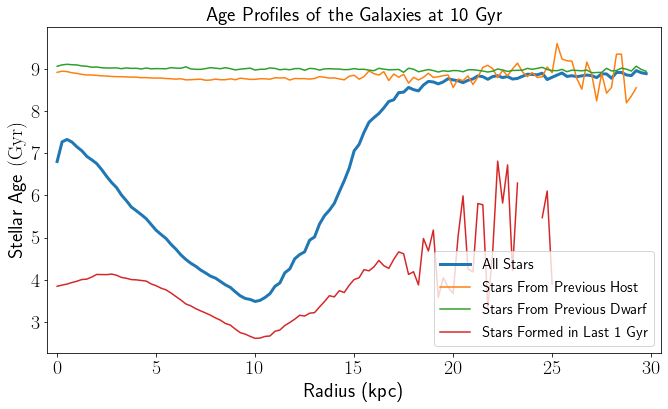

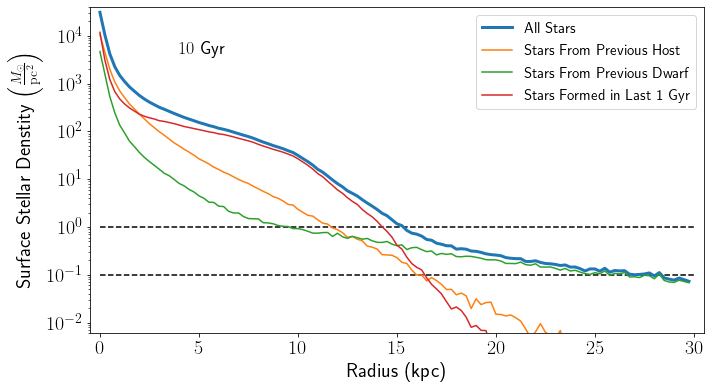

In [304]:
fig, axes1 = plt.subplots(figsize=(11,6))

plt.plot(xaxis.in_units('kpc'), pro_age_all.in_units('Gyr'), label='All Stars', linewidth=3)
plt.plot(xaxis.in_units('kpc'), pro_age_hos.in_units('Gyr'), label='Stars From Previous Host')
plt.plot(xaxis.in_units('kpc'), pro_age_dwa.in_units('Gyr'), label='Stars From Previous Dwarf')
plt.plot(xaxis.in_units('kpc'), pro_age_kid.in_units('Gyr'), label='Stars Formed in Last 1 Gyr')

#plt.yscale('log')
plt.ylabel(r'Stellar Age $(\mathrm{Gyr})$',
           fontsize=20, family='serif', weight='ultralight')
plt.xlabel('Radius (kpc)',fontsize=20, family='serif', weight='ultralight')
plt.xticks(fontsize=20, family='serif')
plt.yticks(fontsize=20, family='serif')
#plt.annotate('$r_{break}$', xy =( float(r_2)-4.5, 1e3), fontsize=18 )
plt.xlim([-0.5,(r_3+0.5*yt.units.kpc).base]);
#plt.vlines(x=r_break[ii], ymin=0, ymax=ii+1, color='#3182bd',linestyle="--")
plt.title('Age Profiles of the Galaxies at %d'%(ii+1)+' Gyr', fontsize=20, family='serif');
plt.legend(fontsize=15);
#plt.savefig('figs/ages/694_%02d'%(ii+1)+'_age_profiles.png',dpi=400,bbox_inches='tight')
plt.show()



fig, axes2 = plt.subplots(figsize=(11,6))

plt.plot(xaxis.in_units('kpc'), pro_den_all.in_units('Msun/pc**2'), label='All Stars', linewidth=3)
plt.plot(xaxis.in_units('kpc'), pro_den_hos.in_units('Msun/pc**2'), label='Stars From Previous Host')
plt.plot(xaxis.in_units('kpc'), pro_den_dwa.in_units('Msun/pc**2'), label='Stars From Previous Dwarf')
plt.plot(xaxis.in_units('kpc'), pro_den_kid.in_units('Msun/pc**2'), label='Stars Formed in Last 1 Gyr')
plt.hlines(y=1e-1, xmin=0, xmax=30, linestyles='dashed')
plt.hlines(y=1e0, xmin=0, xmax=30, linestyles='dashed')

#plt.plot(np.ones(5)*r_1, np.arange(5)*1e4,color='black',linestyle="--")
#plt.plot(np.ones(5)*r_2, np.arange(5)*2e3,color='black',linestyle="--")

plt.yscale('log')
plt.ylabel(r'Surface Stellar Denstity $\left(\frac{M_\odot}{\rm{pc}^2}\right)$',
           fontsize=20, family='serif', weight='ultralight')
plt.xlabel('Radius (kpc)',fontsize=20, family='serif', weight='ultralight')
plt.xticks(fontsize=20, family='serif')
plt.yticks(fontsize=20, family='serif')
plt.annotate('$%2d$'%(ii+1)+' Gyr', xy =( 4, 4e3), fontsize=18 )
plt.xlim([-0.5,(r_3+0.5*yt.units.kpc).base]);
plt.ylim([6e-3,4e4])
#plt.title('Density Profiles of the Galaxy at %d'%(ii+1)+' Gyr', fontsize=20, family='serif');
plt.legend(fontsize=15);
#plt.savefig('figs/694_%02d'%(ii+1)+'_den_profiles.png',dpi=400,bbox_inches='tight')
plt.show()

In [305]:
if xaxis[pro_den_all.in_units('Msun/pc**2')<1].any():
    r_limit1[ii] = xaxis[pro_den_all.in_units('Msun/pc**2')<1][0].in_units('kpc') - r_3/bins
else:
    r_limit1[ii] = np.nan
    
if xaxis[pro_den_all.in_units('Msun/pc**2')<1e-1].any():
    r_limit01[ii] = xaxis[pro_den_all.in_units('Msun/pc**2')<1e-1][0].in_units('kpc') - r_3/bins
else:
    r_limit01[ii] = np.nan

In [306]:
print(r_limit1)
print(r_limit01)

[ 7.   11.   15.   15.5  14.5  14.75 14.75 14.75 14.75 15.25]
[ 8.75 15.     nan 27.25   nan 28.25 28.   27.5  26.75 27.75]


In [242]:
from astropy.convolution import convolve, Box1DKernel
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

def I_fit(r,S,alpha,beta,gamma,r_b):
    return  np.log10(S * np.exp(-1*r/gamma) * ( 1 + np.exp( alpha*(r-r_b) ) )**( 1/alpha * ( 1/gamma - 1/beta ) ) )

def I_show(r,param_set):
    S,alpha,beta,gamma,r_b = param_set.tolist()
    return  S * np.exp(-1*r/gamma) * ( 1 + np.exp( alpha*(r-r_b) ) )**( 1/alpha * ( 1/gamma - 1/beta ) ) 

r_disc    = np.array( xaxis.in_units('kpc') )
dens_disc = np.array( pro_den_all.in_units('Msun/pc**2') )
err_disc  = (np.fabs( err_den_all.in_units('Msun/pc**2') * \
                    1/np.log10(dens_disc)/np.log(10)) ).base

smoothed_den = convolve(np.log10(dens_disc), Box1DKernel(2))
grad = np.gradient(np.gradient(smoothed_den))
grad = grad[(~np.isnan(grad)) & (~np.isinf(grad))]
for i in range(0,20):
    grad=grad[np.fabs(grad-grad.mean())<=3*np.std(grad,ddof=1)]
    #更新一维数组
    #迭代20次,输出是检查循环的进行 
sigma_profile = grad.std(ddof=1) * 1
'''
for i in range(len(np.gradient(np.gradient(smoothed_den)))):
    if np.fabs(np.gradient(np.gradient(smoothed_den)))[i]<=(sigma_profile) and\
        np.fabs(np.gradient(np.gradient(smoothed_den)))[i+1]<=(sigma_profile) and \
        np.fabs(np.gradient(np.gradient(smoothed_den)))[i+2]<=(sigma_profile) and \
        np.fabs(np.gradient(np.gradient(smoothed_den)))[i+3]<=(sigma_profile):
        break
'''
for i in range(len(np.gradient(np.gradient(smoothed_den)))):
    for j in range(9):
        if np.fabs(np.gradient(np.gradient(smoothed_den)))[i+j]>(sigma_profile):
            break
    if j >= 7:
        break

r_in = np.array(xaxis[i].in_units('kpc'))
#r_in = 7
#r_in = res_robust.x[4]#param_set[4]
print(r_in)

for i in range(len(np.gradient(np.gradient(smoothed_den)))):
    for j in range(7):
        if (np.fabs(np.gradient(np.gradient(smoothed_den)))[-1-i-j]>(sigma_profile))\
            | np.isinf(np.fabs(np.gradient(np.gradient(smoothed_den)))[-1-i-j]) \
            | np.isnan(np.fabs(np.gradient(np.gradient(smoothed_den)))[-1-i-j]):
            break
    if j >= 5:
        break

r_out = np.array(xaxis[-1-i].in_units('kpc'))
'''
for i in range(len(np.gradient(np.gradient(smoothed_den)))-1):
    if (i<len(smoothed_den)-1) & (dens_disc[i] < dens_disc[i+1]) & (r_disc[i]>10):
        break
'''
r_out = np.min([r_out, r_disc[dens_disc>1e0][-1]])

r_out = res_robust.x[4]
#r_out = 16#13.5#r_disc[dens_disc > 4e-2][-1]
print(r_out)


param_set, param_cov = curve_fit(I_fit, xdata = r_disc[(r_disc>=r_in)&(r_disc<=r_out)&(dens_disc!=0)],
                                 ydata = np.log10(dens_disc)[(r_disc>=r_in)&(r_disc<=r_out)&(dens_disc!=0)],
                                 #sigma = err_disc[(r_disc>=r_in)&(r_disc<=r_out)&(dens_disc!=0)],
                                 bounds=([0,0.1,0,0,r_in], [np.inf,1,np.inf,np.inf,r_out]),#p0=[1,0.5,1,1,0.5*(min(r_disc)+max(r_disc))],
                                 maxfev = 1000000)

if (param_set[2]/param_set[3] > 1.1) or (param_set[2]/param_set[3] < 1/1.1) and (r_in+0.5<=param_set[4]):
    r_break1[ii] = param_set[4]
else:
    r_break1[ii] = np.nan
oiratio1[ii] = param_set[2]/param_set[3]
print(param_set)

1.7499999999999998
15.499999999999998
[9.84592663e+02 1.00000000e+00 3.15577004e+05 2.08341770e+00
 1.46409550e+01]


In [243]:
def I_rob(param_set, r, y):
    S, alpha, beta, gamma, r_b = param_set.tolist()
    return np.log10(S * np.exp(-1 * r / gamma) *
                    (1 + np.exp(alpha *
                                (r - r_b)))**(1 / alpha *
                                              (1 / gamma - 1 / beta))) - y


res_robust = least_squares(
    I_rob,
    x0 = param_set,
    bounds=([0,0,0,0,r_in], [np.inf,np.inf,np.inf,np.inf,r_out]),
    loss='soft_l1',
    f_scale=0.01,
    args=(r_disc[(r_disc >= r_in) & (r_disc <= r_out) & (dens_disc != 0)],
          np.log10(dens_disc)[(r_disc >= r_in) & (r_disc <= r_out) &
                              (dens_disc != 0)]))
if (res_robust.success==True) & (res_robust.x[-1]>r_in+1) & (res_robust.x[-1]<r_out-1) \
    & ((res_robust.x[2]/res_robust.x[3]>1.1 or res_robust.x[2]/res_robust.x[3]<1/1.1)):
    r_break1[ii] = (res_robust.x)[4]
    oiratio1[ii] = (res_robust.x)[2] / (res_robust.x)[3]
else:
    r_break1[ii] = np.nan
    oiratio1[ii] = np.nan
res_robust.x, res_robust.success, oiratio1[ii]

(array([945.7727158 ,   3.42301289,   3.87879421,   2.08333113,
         12.77079767]), True, 1.8618231860617154)

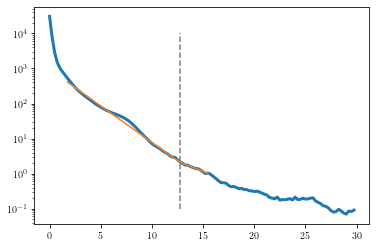

In [244]:
plt.plot(xaxis.in_units('kpc'), pro_den_all.in_units('Msun/pc**2'), linewidth=3)
plt.plot(r_disc[(r_disc>=r_in)&(r_disc<=r_out)], I_show(np.array(r_disc[(r_disc>=r_in)&(r_disc<=r_out)]),res_robust.x) )
plt.vlines(r_break1[ii], ymin=1e-1, ymax=1e4, linestyles='dashed', alpha=0.5)
plt.yscale('log');

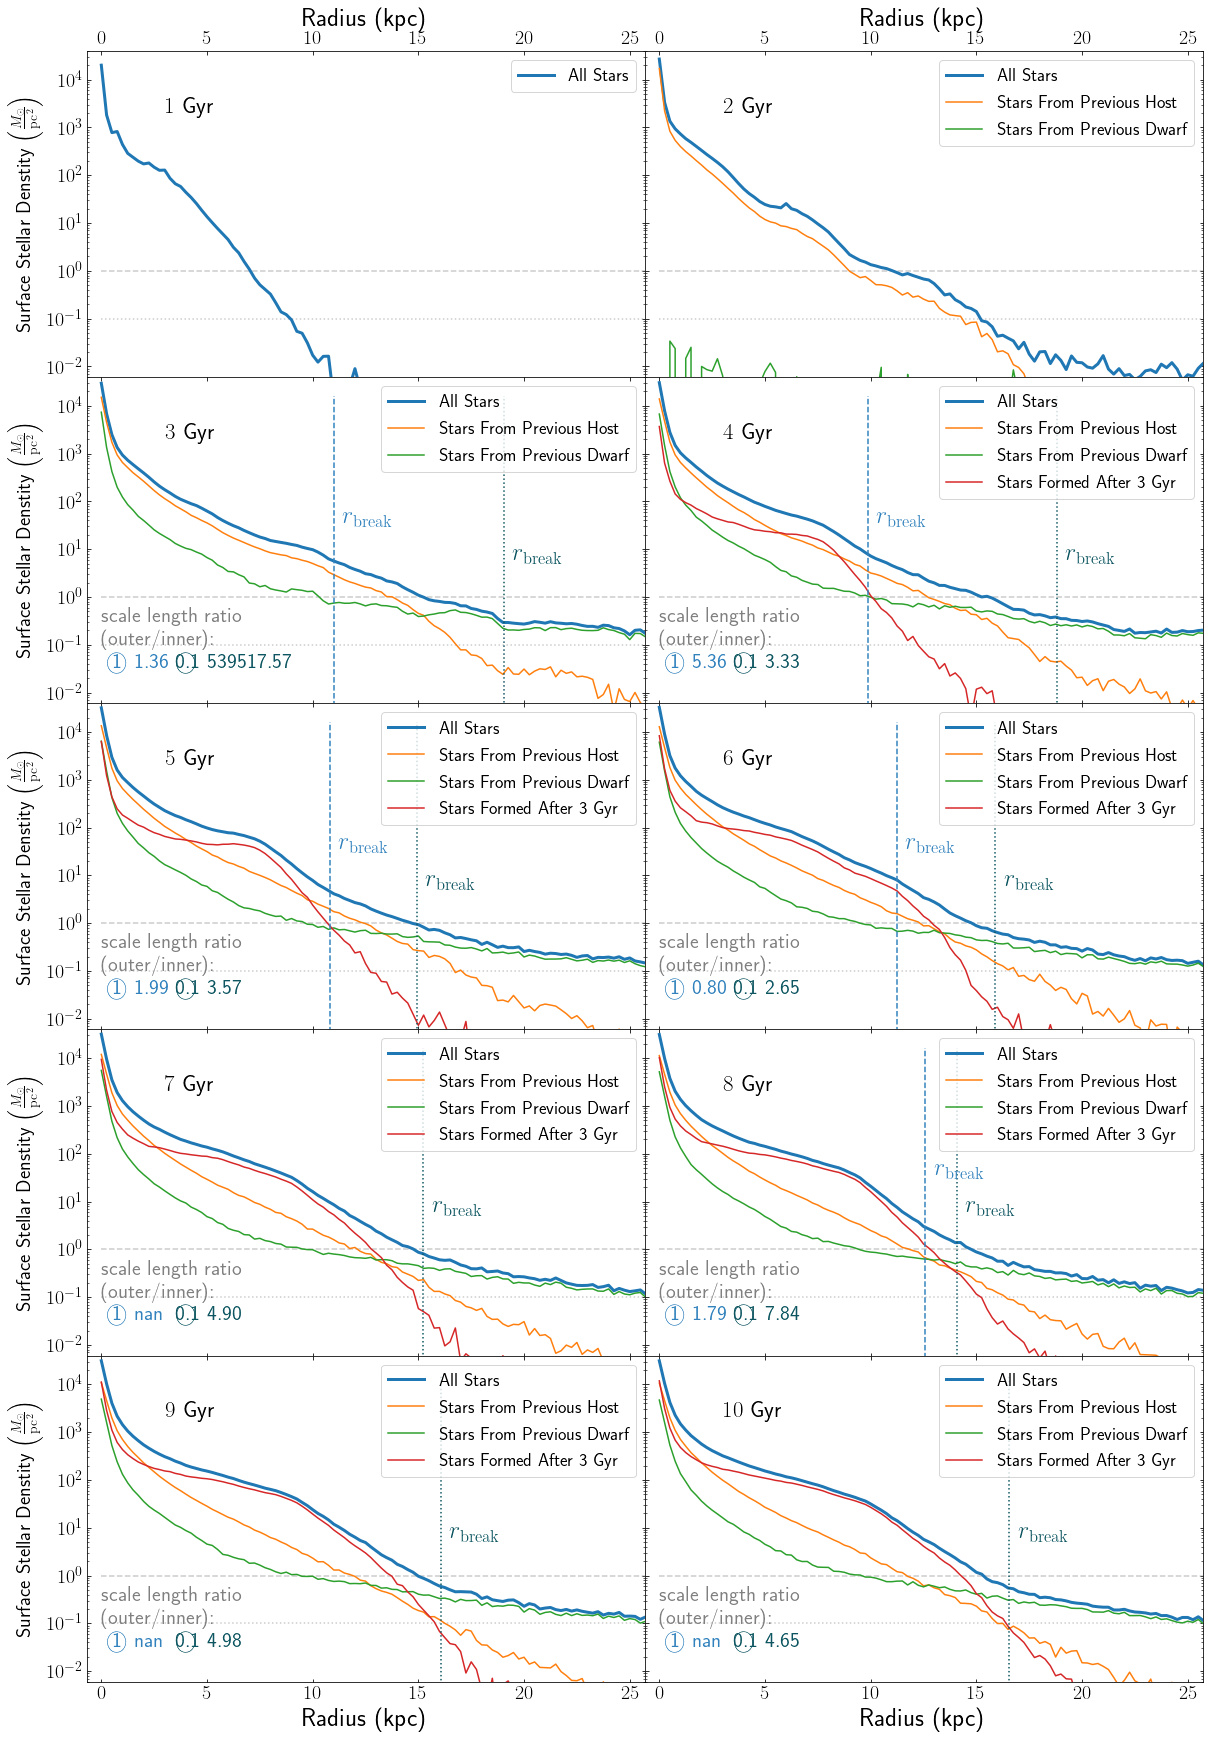

In [314]:
fig, axes = plt.subplots(5, 2, figsize=(20, 30))

for i in range(5):
    for j in range(2):
        ds = ds_array[Gyr_list[i*2+j]]
        centerHost = centerH_array[2*i+j]
        sphHost1 = ds.sphere(centerHost, (20, 'kpc'))
        sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
        #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
        norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
        north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]

        host_galaxy = ds.disk(centerHost, norm_host, radius=30*yt.units.kpc, height=30*yt.units.kpc)
        host_galaxy.clear_data()
        v_b = host_galaxy.quantities.bulk_velocity(use_gas=False, use_particles=True, particle_type='Stars')
        host_galaxy.set_field_parameter('bulk_velocity', v_b)
        
        r_cylindrical = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 \
                                + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')
        

        index_dwarf_i = index_dwarf[:ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[Gyr_list[2*i+j-1]].current_time)
        index_host_i  = index_host[ :ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[Gyr_list[2*i+j-1]].current_time)
        if 2*i+j<3:
            index_sf_i = index_host_i
        #if (2*i+j<6) & (2*i+j>0):
        #    index_sf_i    = (ds.all_data()['Stars','FormationTime']>ds_array[2*i+j-1].current_time) & index_theta_i #index_sf[   :ds.particle_type_counts['Stars']]
        if 2*i+j>2:
            index_sf_i    = index_sf1[   :ds.particle_type_counts['Stars']]

        ds.add_particle_filter('Stars_from_dwarf')
        ds.add_particle_filter('Stars_from_host')
        ds.add_particle_filter('Stars_young')

        
        index_dwa_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_dwarf', 'iord'])
        index_hos_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_host', 'iord'])
        index_kid_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_young', 'iord'])

        xaxis, pro_den_all, pro_age_all, err_den_all = Profile_synthesis( Radius=r_cylindrical,
                                                          Mass=host_galaxy['Stars','Mass'],
                                                            FormationTime=host_galaxy['Stars','FormationTime'],
                                                          n_bins=bins )
        xaxis, pro_den_dwa, pro_age_dwa, err_den_dwa = Profile_synthesis( Radius=r_cylindrical[index_dwa_in_gala],
                                                          Mass=host_galaxy['Stars','Mass'][index_dwa_in_gala],
                                                            FormationTime=host_galaxy['Stars','FormationTime'][index_dwa_in_gala],
                                                          n_bins=bins )
        xaxis, pro_den_hos, pro_age_hos, err_den_hos = Profile_synthesis( Radius=r_cylindrical[index_hos_in_gala],
                                                          Mass=host_galaxy['Stars','Mass'][index_hos_in_gala],
                                                            FormationTime=host_galaxy['Stars','FormationTime'][index_hos_in_gala],
                                                          n_bins=bins )
        xaxis, pro_den_kid, pro_age_kid, err_den_kid = Profile_synthesis( Radius=r_cylindrical[index_kid_in_gala],
                                                          Mass=host_galaxy['Stars','Mass'][index_kid_in_gala],
                                                            FormationTime=host_galaxy['Stars','FormationTime'][index_kid_in_gala],
                                                          n_bins=bins )
        
        
        axes[i, j].plot(xaxis.in_units('kpc'), pro_den_all.in_units('Msun/pc**2'), label='All Stars', linewidth=3)
        if ((i!=0) | (j!=0)) & (i*2+j<3):
            axes[i, j].plot(xaxis.in_units('kpc'), pro_den_hos.in_units('Msun/pc**2'), label='Stars From Previous Host')
            axes[i, j].plot(xaxis.in_units('kpc'), pro_den_dwa.in_units('Msun/pc**2'), label='Stars From Previous Dwarf')
        #    axes[i, j].plot(xaxis.in_units('kpc'), pro_den_kid.in_units('Msun/pc**2'), label='Stars Formed in Last 1 Gyr')
        if ((i!=0) | (j!=0)) & (i*2+j>2):
            axes[i, j].plot(xaxis.in_units('kpc'), pro_den_hos.in_units('Msun/pc**2'), label='Stars From Previous Host')
            axes[i, j].plot(xaxis.in_units('kpc'), pro_den_dwa.in_units('Msun/pc**2'), label='Stars From Previous Dwarf')
            axes[i, j].plot(xaxis.in_units('kpc'), pro_den_kid.in_units('Msun/pc**2'), label='Stars Formed After 3 Gyr')
        if (~np.isnan( r_break1[i*2+j] and r_break01[i*2+j] )):
            axes[i, j].annotate('scale length ratio \n (outer/inner):', xy =( 0, 1e-1), fontsize=21, color='grey' )
            axes[i, j].annotate('$r_\mathrm{break}$', xy =( r_break1[i*2+j]+0.4, 3e1), fontsize=24, color='#3182bd' )
            axes[i, j].plot(np.ones(5)*r_break1[i*2+j], np.arange(5)*4e3,color='#3182bd',linestyle="--")
            axes[i, j].annotate(r'\textcircled{1} %.2f'%oiratio1[i*2+j],xy=(0.25,10**-1.5), fontsize=21, color='#3182bd' )
            axes[i, j].annotate('$r_\mathrm{break}$', xy =( r_break01[i*2+j]+0.4, 0.5e1), fontsize=24, color='#0D5661' )
            axes[i, j].plot(np.ones(5)*r_break01[i*2+j], np.arange(5)*4e3,color='#0D5661',linestyle=":")
            axes[i, j].annotate(r'\textcircled{0.1} %.2f'%oiratio01[i*2+j],xy=(3.5,10**-1.5), fontsize=21, color='#0D5661' )
        axes[i ,j].hlines( y=1e-1, xmax=xaxis.in_units('kpc').max(), xmin=xaxis.in_units('kpc').min(), linestyle=':', color='grey', alpha=0.4 )
        axes[i ,j].hlines( y=1e0, xmax=xaxis.in_units('kpc').max(), xmin=xaxis.in_units('kpc').min(), linestyle='dashed', color='grey', alpha=0.4 )
        
        
        #axes[i, j].plot(np.ones(5)*r_1, np.arange(5)*1e4,color='black',linestyle="--")
        #axes[i, j].plot(np.ones(5)*r_2, np.arange(5)*2e3,color='black',linestyle="--")
        axes[i, j].set_xlim([-0.7,((25+0.7)*yt.units.kpc).base]);
        axes[i, j].set_ylim([6e-3,4e4])
        axes[i, j].set_yscale('log')
        axes[i, j].set_xlabel('Radius (kpc)', fontdict={'fontsize':25, 
                                                        'fontweight': 'ultralight',
                                                        'family':'serif'}
                                )
        #axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), fontdict={'fontsize':20, 'fontweight': 'ultralight'} )
        axes[i, j].set_ylabel(r'Surface Stellar Denstity $\left(\frac{M_\odot}{\rm{pc}^2}\right)$',
                                fontdict={'fontsize':20, 
                                'fontweight': 'ultralight'}
                                )
        #axes[i, j].set_yticklabels(axes[i, j].get_ymajorticklabels(),fontdict={'fontsize':20, 'fontweight': 'ultralight'} )
        axes[i, j].annotate('$%d$'%(2*i+j+1)+' Gyr', xy =( 3, 2e3), fontsize=23 )
        axes[i, j].legend(fontsize=18,loc=1);
        
        axes[i, j].xaxis.set_ticks_position('both')
        if (i == 1) or ( i == 2 ) or ( i == 3 ):
            axes[i, j].get_shared_x_axes().join(axes[i, j], axes[i-1, j])
            axes[i, j].set_xticklabels([])
        if i == 0:
            axes[i, j].get_shared_x_axes().join(axes[i, j], axes[i-1, j])
            axes[i, j].xaxis.set_label_position('top')
            axes[i, j].xaxis.set_ticks_position('top')
        axes[i, j].yaxis.set_ticks_position('both')
        if j == 1:
            axes[i, j].get_shared_y_axes().join(axes[i, j], axes[i, j-1])
            axes[i, j].set_yticklabels([])
            axes[i, j].set_ylabel('')
            
        axes[i, j].tick_params(direction='in',which='both',labelsize=20)
        
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('figs/multiplot_profiles_all.png', dpi=500, bbox_inches='tight')

In [315]:
# density profile
for ii in range(len(time_list)):
    ds = ds_array[ii]
    centerHost = centerH_array[ii]
    sphHost1 = ds.sphere(centerHost, (20, 'kpc'))
    sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
    del sphHost1
    #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
    norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
    north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]

    host_galaxy = ds.disk(centerHost, norm_host, radius=30*yt.units.kpc, height=200*yt.units.kpc)
    host_galaxy.clear_data()
    v_b = host_galaxy.quantities.bulk_velocity(use_gas=False, use_particles=True, particle_type='Stars')
    host_galaxy.set_field_parameter('bulk_velocity', v_b)

    r_cylindrical = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 \
                            + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')
    

    index_dwarf_i = index_dwarf[:ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[ii-1].current_time) 
    index_host_i  = index_host[ :ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[ii-1].current_time) 
    if ii==0:
        index_sf_i = index_host_i
    if (ii<3) & (ii>0):
        index_sf_i    = (ds.all_data()['Stars','FormationTime']>ds_array[ii-1].current_time)  #index_sf[   :ds.particle_type_counts['Stars']]
    if ii>2:
        index_sf_i    = index_sf1[   :ds.particle_type_counts['Stars']]
    
    ds.add_particle_filter('Stars_on_disk')
    ds.add_particle_filter('Stars_from_dwarf')
    ds.add_particle_filter('Stars_from_host')
    ds.add_particle_filter('Stars_young')

    
    index_dwa_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_dwarf', 'iord'])
    index_hos_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_host', 'iord'])
    index_kid_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_young', 'iord'])

    
    xaxis, pro_den_all, pro_age_all, err_den_all = Profile_synthesis( Radius=r_cylindrical,
                                                      Mass=host_galaxy['Stars','Mass'],
                                                        FormationTime=host_galaxy['Stars','FormationTime'],
                                                      n_bins=bins )
    xaxis, pro_den_dwa, pro_age_dwa, err_den_dwa = Profile_synthesis( Radius=r_cylindrical[index_dwa_in_gala],
                                                      Mass=host_galaxy['Stars','Mass'][index_dwa_in_gala],
                                                        FormationTime=host_galaxy['Stars','FormationTime'][index_dwa_in_gala],
                                                      n_bins=bins )
    xaxis, pro_den_hos, pro_age_hos, err_den_hos = Profile_synthesis( Radius=r_cylindrical[index_hos_in_gala],
                                                      Mass=host_galaxy['Stars','Mass'][index_hos_in_gala],
                                                        FormationTime=host_galaxy['Stars','FormationTime'][index_hos_in_gala],
                                                      n_bins=bins )
    xaxis, pro_den_kid, pro_age_kid, err_den_kid = Profile_synthesis( Radius=r_cylindrical[index_kid_in_gala],
                                                      Mass=host_galaxy['Stars','Mass'][index_kid_in_gala],
                                                        FormationTime=host_galaxy['Stars','FormationTime'][index_kid_in_gala],
                                                      n_bins=bins )
    
    fig, axes = plt.subplots(1, 1, figsize=(15, 8))

    axes.plot(xaxis.in_units('kpc'), pro_den_all.in_units('Msun/pc**2'), label='All Stars', linewidth=3)
    if (ii!=0) & (ii<3):
        axes.plot(xaxis.in_units('kpc'), pro_den_hos.in_units('Msun/pc**2'), label='Stars From Previous Host')
        axes.plot(xaxis.in_units('kpc'), pro_den_dwa.in_units('Msun/pc**2'), label='Stars From Previous Dwarf')
        axes.plot(xaxis.in_units('kpc'), pro_den_kid.in_units('Msun/pc**2'), label='Stars Formed since Last Snapshot')
    if (ii!=0) & (ii>2):
        axes.plot(xaxis.in_units('kpc'), pro_den_hos.in_units('Msun/pc**2'), label='Stars From Previous Host')
        axes.plot(xaxis.in_units('kpc'), pro_den_dwa.in_units('Msun/pc**2'), label='Stars From Previous Dwarf')
        axes.plot(xaxis.in_units('kpc'), pro_den_kid.in_units('Msun/pc**2'), label='Stars Formed After 3 Gyr')
    if (~np.isnan( r_break1[ii] and r_break01[ii] )):
        axes.annotate('scale length ratio \n (outer/inner):', xy =( 0, 1e-1), fontsize=21, color='grey' )
        axes.annotate('$r_\mathrm{break}$', xy =( r_break1[ii]+0.4, 3e1), fontsize=24, color='#3182bd' )
        axes.plot(np.ones(5)*r_break1[ii], np.arange(5)*4e3,color='#3182bd',linestyle="--")
        axes.annotate(r'\textcircled{1} %.2f'%oiratio1[ii],xy=(0.25,10**-1.5), fontsize=21, color='#3182bd' )
        axes.annotate('$r_\mathrm{break}$', xy =( r_break01[ii]+0.4, 0.5e1), fontsize=24, color='#0D5661' )
        axes.plot(np.ones(5)*r_break01[ii], np.arange(5)*4e3,color='#0D5661',linestyle=":")
        axes.annotate(r'\textcircled{0.1} %.2f'%oiratio01[ii],xy=(3.5,10**-1.5), fontsize=21, color='#0D5661' )
        
    axes.hlines( y=1,  xmax=xaxis.in_units('kpc').max(), xmin=xaxis.in_units('kpc').min(), linestyle='--', color='grey', alpha=0.4)
    axes.hlines( y=1e-1, xmax=xaxis.in_units('kpc').max(), xmin=xaxis.in_units('kpc').min(), linestyle=':', color='grey', alpha=0.6 )

    #axes.plot(np.ones(5)*r_1, np.arange(5)*1e4,color='black',linestyle="--")
    #axes.plot(np.ones(5)*r_2, np.arange(5)*2e3,color='black',linestyle="--")
    axes.set_xlim([-0.7,((25+0.7)*yt.units.kpc).base]);
    axes.set_ylim([6e-3,4e4])
    axes.set_yscale('log')
    axes.tick_params(direction='in',which='both',labelsize=20)
    axes.set_xlabel('Radius (kpc)', fontdict={'fontsize':25, 
                                            'fontweight': 'ultralight',
                                            'family':'serif'}
                            )
    #axes.set_xticklabels(axes[i, j].get_xticklabels(), fontdict={'fontsize':20, 'fontweight': 'ultralight'} )
    axes.set_ylabel(r'Surface Stellar Denstity $\left(\frac{M_\odot}{\rm{pc}^2}\right)$',
                    fontdict={'fontsize':20, 
                    'fontweight': 'ultralight'}
                    )
    #axes.set_yticklabels(axes[i, j].get_ymajorticklabels(),fontdict={'fontsize':20, 'fontweight': 'ultralight'} )
    axes.annotate('$%.1f$'%(time_list[ii]/10)+' Gyr', xy =( 3, 2e3), fontsize=23 )
    axes.legend(fontsize=18,loc=1);
    plt.title('run694 k20i0', fontsize=20, family='serif', weight='ultralight')
    plt.savefig('figs/density_pros/%d_all.png'%time_list[ii], dpi=500, bbox_inches='tight')
    plt.close()

In [313]:
# velocity dispersion beta
component = ['r', r'\theta', r'\phi']
for ii in range(len(time_list)):
#for ii in [27, 28, 29, 30, 31, 32, 33, 34, 35]:
    ds = ds_array[ii]
    centerHost = centerH_array[ii]
    sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
    sphHost_4_norm.clear_data()
    v_b = sphHost_4_norm.quantities.bulk_velocity(use_gas=False, use_particles=True, particle_type='Stars')
    #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
    norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
    north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]

    host_galaxy = ds.disk(centerHost, norm_host, radius=30*yt.units.kpc, height=200*yt.units.kpc)
    host_galaxy.clear_data()
    v_b = host_galaxy.quantities.bulk_velocity(use_gas=False, use_particles=True, particle_type='Stars')
    host_galaxy.set_field_parameter('bulk_velocity', v_b)

    r_cylindrical = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 \
                            + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')
    
    index_theta_i = np.ones(ds.particle_type_counts['Stars'], bool)
    index_dwarf_i = index_dwarf[:ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[ii-1].current_time) 
    index_host_i  = index_host[ :ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[ii-1].current_time) 
    if ii==0:
        index_sf_i = index_host_i
    if (ii<3) & (ii>0):
        print
        index_sf_i    = (ds.all_data()['Stars','FormationTime']>ds_array[ii-1].current_time) #index_sf[   :ds.particle_type_counts['Stars']]
    if ii>2:
        index_sf_i    = index_sf1[   :ds.particle_type_counts['Stars']]
    
    ds.add_particle_filter('Stars_on_disk')
    ds.add_particle_filter('Stars_from_dwarf')
    ds.add_particle_filter('Stars_from_host')
    ds.add_particle_filter('Stars_young')

    index_dis_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_on_disk', 'iord'])
    index_dwa_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_dwarf', 'iord'])
    index_hos_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_host', 'iord'])
    index_kid_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_young', 'iord'])
    
    Velocity = velocity_cylinder( host_galaxy['Stars', 'particle_velocity_relative'],
                                 host_galaxy['Stars', 'particle_position_relative'])
    
    
    nbins= 50
    
    xaxis, pro_v_all, err_v_all = Profile_average( Radius=r_cylindrical,
                                                 Mass=host_galaxy['Stars','Mass'],
                                                 Param=Velocity,
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    '''
    xaxis, pro_v_dwa, err_v_dwa = Profile_average( Radius=r_cylindrical[index_dwa_in_gala],
                                                 Mass=host_galaxy['Stars','Mass'][index_dwa_in_gala],
                                                 Param=Velocity[index_dwa_in_gala],
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    xaxis, pro_v_hos, err_v_hos = Profile_average( Radius=r_cylindrical[index_hos_in_gala],
                                                 Mass=host_galaxy['Stars','Mass'][index_hos_in_gala],
                                                 Param=Velocity[index_hos_in_gala],
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    '''
    xaxis, pro_v_kid, err_v_kid = Profile_average( Radius=r_cylindrical[index_kid_in_gala],
                                                 Mass=host_galaxy['Stars','Mass'][index_kid_in_gala],
                                                 Param=Velocity[index_kid_in_gala],
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    
    fig = plt.figure(figsize=(11,6))
    beta2 = 1 - (err_v_kid[:,1]**2 + err_v_kid[:,2]**2) / (2 * err_v_kid[:,0]**2)
    beta1 = 1 - (err_v_all[:,1]**2 + err_v_all[:,2]**2) / (2 * err_v_all[:,0]**2)
    plt.plot(xaxis.in_units('kpc'), beta1, label='All Stars')
    if ii < 3:
        plt.plot(xaxis.in_units('kpc'), beta2, label='Young Stars (during last 1 Gyr)')
    if ii > 2:
        plt.plot(xaxis.in_units('kpc'), beta2, label='Young Stars (after 3 Gyr)')
    plt.hlines(y=0, xmin=0, xmax=30, linestyle='dashed', color='grey', alpha=0.4)
    if (~np.isnan( r_break1[ii] and r_break01[ii] )):
        plt.annotate('$r_\mathrm{break}$', xy =( r_break1[ii]+0.4, 0.8), fontsize=24, color='#3182bd' )
        plt.vlines(r_break1[ii], ymin=-1.1, ymax=1.1, color='#3182bd',linestyle="--")
        plt.annotate('$r_\mathrm{break}$', xy =( r_break01[ii]+0.4, -0.3), fontsize=24, color='#0D5661' )
        plt.vlines(r_break01[ii], ymin=-1.1, ymax=1.1, color='#0D5661',linestyle=":")
    if (~np.isnan( r_limit1[ii] or r_limit01[ii] )):
        plt.vlines(r_limit1[ii], ymin=-1.1, ymax=1.1, color='grey',linestyle="--")
        plt.annotate('$r_\mathrm{1}$', xy =( r_limit1[ii]+0.4, 0.2), fontsize=24, color='grey' )
        plt.vlines(r_limit01[ii], ymin=-1.1, ymax=1.1, color='grey',linestyle=":")
        plt.annotate('$r_\mathrm{0.1}$', xy =( r_limit01[ii]+0.4, -0.5), fontsize=24, color='grey' )
    plt.ylim([-1.35, 1.35])
    #plt.vlines(r_break[ii], ymin=0, ymax=4.5, color='#3182bd', linestyle="--")
    plt.ylabel(r'$\beta$',
               fontsize=20, family='serif', weight='ultralight')
    plt.xlabel('Radius (kpc)',fontsize=20, family='serif', weight='ultralight')
    plt.xticks(fontsize=20, family='serif')
    plt.yticks(fontsize=17, family='serif')
    plt.title( 'run694k20i0 %.1f Gyr'%(time_list[ii]/10),
              fontsize=20, family='serif', weight='ultralight' )
    #plt.annotate('$%d$'%(ii+1)+' Gyr', xy =( 3, 190), fontsize=23 )
    plt.legend(fontsize=15, loc=4);
    plt.savefig(r'figs/dispersion2/1_all_%d'%(time_list[ii])+'.png' );
    plt.close();

/Users/protesticon/anaconda3/lib/python3.7/site-packages/yt/fields/derived_field.py:256: VisibleDeprecationWarning: The 'particle_velocity_relative' field has been deprecated in favor of 'relative_particle_velocity'.
  dd = self._function(self, data)
/Users/protesticon/anaconda3/lib/python3.7/site-packages/yt/fields/derived_field.py:256: VisibleDeprecationWarning: The 'particle_position_relative' field has been deprecated in favor of 'relative_particle_position'.
  dd = self._function(self, data)
/Users/protesticon/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/protesticon/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/protesticon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empt

In [312]:
# metallicity profile
for ii in range(len(time_list)):
    ds = ds_array[ii]
    density = ds.all_data()[('Gas', 'Density')]
    target  = np.where(density == density.max())[0][0]
    del density
    centerHost = ds.all_data()[('Gas', 'Coordinates')][target].in_units('kpc')
    sphHost0 = ds.sphere(centerHost, (20, 'kpc')) 
    centerHost = sphHost0.quantities.center_of_mass(use_gas=False, use_particles=True, particle_type='Stars')
    sphHost1 = ds.sphere(centerHost, (20, 'kpc'))
    sphHost_4_norm = ds.sphere(centerHost, (4, 'kpc'))
    #计算 host 的角动量，作为其法线方向，再算出与法向量垂直的一个向量，当做画图时的北方
    norm_host  = sphHost_4_norm.quantities.angular_momentum_vector(use_gas=False, use_particles=True, particle_type='Stars')
    north_host = yt.YTArray(yt.ortho_find(norm_host), 'kpc')[1]

    host_galaxy = ds.disk(centerHost, norm_host, radius=30*yt.units.kpc, height=200*yt.units.kpc)
    host_galaxy.clear_data()
    v_b = host_galaxy.quantities.bulk_velocity(use_gas=False, use_particles=True, particle_type='Stars')
    host_galaxy.set_field_parameter('bulk_velocity', v_b)

    r_cylindrical = np.sqrt( (host_galaxy[('Stars', 'particle_position_relative_x')])**2 \
                            + (host_galaxy[('Stars', 'particle_position_relative_y')])**2 ).in_units('kpc')
    
    index_theta_i = np.ones(ds.particle_type_counts['Stars'], bool)
    index_dwarf_i = index_dwarf[:ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[ii-1].current_time) 
    index_host_i  = index_host[ :ds.particle_type_counts['Stars']] & (ds.all_data()['Stars','FormationTime']<=ds_array[ii-1].current_time) 
    if ii==0:
        index_sf_i = index_host_i
    if (ii<3) & (ii>0):
        index_sf_i    = (ds.all_data()['Stars','FormationTime']>ds_array[ii-1].current_time) #index_sf[   :ds.particle_type_counts['Stars']]
    if ii>2:
        index_sf_i    = index_sf1[   :ds.particle_type_counts['Stars']]
    
    ds.add_particle_filter('Stars_on_disk')
    ds.add_particle_filter('Stars_from_dwarf')
    ds.add_particle_filter('Stars_from_host')
    ds.add_particle_filter('Stars_young')

    index_dis_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_on_disk', 'iord'])
    index_dwa_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_dwarf', 'iord'])
    index_hos_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_from_host', 'iord'])
    index_kid_in_gala = np.isin( host_galaxy['Stars','iord'], ds.all_data()['Stars_young', 'iord'])
    
    Metal = host_galaxy['Stars', 'Metals']
    
    nbins= 50
    xaxis, pro_met_all, err_met_all = Profile_average( Radius=r_cylindrical,
                                                 Mass=host_galaxy['Stars','Mass'],
                                                 Param=Metal,#AM[:,1],
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    xaxis, pro_met_dwa, err_met_dwa = Profile_average( Radius=r_cylindrical[index_dwa_in_gala],
                                                 Mass=host_galaxy['Stars','Mass'][index_dwa_in_gala],
                                                 Param=Metal[index_dwa_in_gala],
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    xaxis, pro_met_hos, err_met_hos = Profile_average( Radius=r_cylindrical[index_hos_in_gala],
                                                 Mass=host_galaxy['Stars','Mass'][index_hos_in_gala],
                                                 Param=Metal[index_hos_in_gala],
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    xaxis, pro_met_kid, err_met_kid = Profile_average( Radius=r_cylindrical[index_kid_in_gala],
                                                 Mass=host_galaxy['Stars','Mass'][index_kid_in_gala],
                                                 Param=Metal[index_kid_in_gala],
                                                 Rrange=30*yt.units.kpc,
                                                 n_bins=nbins )
    
    fig = plt.figure(figsize=(11,6))
    plt.plot(xaxis.in_units('kpc'), pro_met_all.in_cgs(), label='All Stars', linewidth=3)
    plt.fill_between(xaxis.in_units('kpc'), (pro_met_all+err_met_all).in_cgs(),
                     (pro_met_all-err_met_all).in_cgs(), alpha=0.5)
    #plt.vlines(r_break[ii], ymin=0, ymax=200, color='#3182bd', linestyle="--")
    plt.hlines( y=0, xmin=0, xmax=30, linestyles='--', colors='k')
    if (ii!=0) & (ii<3):
        plt.plot(xaxis.in_units('kpc'), pro_met_hos.in_cgs(), label='Stars From Previous Host')
        plt.plot(xaxis.in_units('kpc'), pro_met_dwa.in_cgs(), label='Stars From Previous Dwarf')
        plt.plot(xaxis.in_units('kpc'), pro_met_kid.in_cgs(), label='Stars Formed since Last Snapshot')
    if (ii!=0) & (ii>2):
        plt.plot(xaxis.in_units('kpc'), pro_met_hos.in_cgs(), label='Stars From Previous Host')
        plt.plot(xaxis.in_units('kpc'), pro_met_dwa.in_cgs(), label='Stars From Previous Dwarf')
        plt.plot(xaxis.in_units('kpc'), pro_met_kid.in_cgs(), label='Stars Formed After 5 Gyr', color='#C1328E')
    if (~np.isnan( r_break1[ii] or r_break01[ii] )):
        plt.annotate('$r_\mathrm{break}$', xy =( r_break1[ii]+0.4, 0.03), fontsize=24, color='#3182bd' )
        plt.vlines(r_break1[ii], ymin=-0.001, ymax=0.041, color='#3182bd',linestyle="--")
        plt.annotate('$r_\mathrm{break}$', xy =( r_break01[ii]+0.4, 0.02), fontsize=24, color='#0D5661' )
        plt.vlines(r_break01[ii], ymin=-0.001, ymax=0.041, color='#0D5661',linestyle=":")
    if (~np.isnan( r_limit1[ii] or r_limit01[ii] )):
        plt.vlines(r_limit1[ii], ymin=-0.001, ymax=0.041, color='grey',linestyle="--")
        plt.annotate('$r_\mathrm{1}$', xy =( r_limit1[ii]+0.4, 0.02), fontsize=24, color='grey' )
        plt.vlines(r_limit01[ii], ymin=-0.001, ymax=0.041, color='grey',linestyle=":")
        plt.annotate('$r_\mathrm{0.1}$', xy =( r_limit01[ii]+0.4, 0.015), fontsize=24, color='grey' )
    
    #plt.xlim([-0.7,30.7]);
    plt.xlim([-1,31])
    plt.ylim([-0.002, 0.042]);
    plt.ylabel(r'$Z$',
               fontsize=20, family='serif', weight='ultralight')
    plt.xlabel('Radius (kpc)',fontsize=20, family='serif', weight='ultralight')
    plt.xticks(fontsize=20, family='serif')
    plt.yticks(fontsize=17, family='serif')
    plt.title( 'Metallicity at %.1f Gyr'%(time_list[ii]/10), fontsize=20, family='serif', weight='ultralight' )
    #plt.annotate('$%d$'%(ii+1)+' Gyr', xy =( 3, 190), fontsize=23 )
    plt.legend(fontsize=15, loc=1);
    plt.savefig('figs/metal/%d'%(time_list[ii])+'_all.png' );
    plt.close();

/Users/protesticon/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/protesticon/anaconda3/lib/python3.7/site-packages/yt/units/yt_array.py:1394: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)
/Users/protesticon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice.


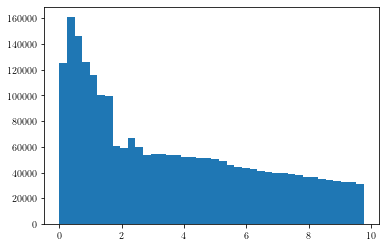

In [316]:
ii = -1
ds = ds_array[ii]
plt.hist( ds.all_data()['Stars', 'FormationTime'].in_units('Gyr').base, bins=40 );